In [1]:
!mkdir  -p ~/.kaggle
!mv  kaggle.json  ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100%|███████████████████████████████████████▊| 583M/586M [00:19<00:00, 28.2MB/s]
100%|████████████████████████████████████████| 586M/586M [00:19<00:00, 31.8MB/s]


In [ ]:
!unzip animals10.zip

In [4]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}


In [22]:
import os
from sklearn.model_selection import train_test_split
import shutil
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,ConcatDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time
import torch.nn.functional as FF
import torchvision.transforms.functional as F
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import random
from PIL import Image

In [6]:
data_dir='/kaggle/working/raw-img'

for folder_name in os.listdir(data_dir):
  if folder_name in translate:
    older_file_path=os.path.join(data_dir,folder_name)
    new_folder_name=translate[folder_name]
    new_folder_path=os.path.join(data_dir,new_folder_name)
    os.rename(older_file_path,new_folder_path)
    print(f'Renamed {folder_name} to {new_folder_path}')


Renamed scoiattolo to /kaggle/working/raw-img/squirrel
Renamed cavallo to /kaggle/working/raw-img/horse
Renamed pecora to /kaggle/working/raw-img/sheep
Renamed gatto to /kaggle/working/raw-img/cat
Renamed cane to /kaggle/working/raw-img/dog
Renamed mucca to /kaggle/working/raw-img/cow
Renamed elefante to /kaggle/working/raw-img/elephant
Renamed farfalla to /kaggle/working/raw-img/butterfly
Renamed gallina to /kaggle/working/raw-img/chicken


In [9]:
import pandas as pd

data = []

for animal in os.listdir(root_dir):
    animal_path = os.path.join(root_dir, animal)
    if os.path.isdir(animal_path):
        all_files = os.listdir(animal_path)
        train_files, temp_files = train_test_split(all_files, test_size=(1 - train_ratio))
        validate_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (test_ratio + validate_ratio)))
        
        for file_name in all_files:
            file_path = os.path.join(animal_path, file_name)
            class_name = animal  # Assuming class name is the name of the animal directory
            data.append((file_path, class_name))

# Create DataFrame
df = pd.DataFrame(data, columns=['File_Path', 'Class'])
df

,File_Path,Class
0,/kaggle/working/raw-img/cow/OIP-4Q5uYog_JK-mbf...,cow
1,/kaggle/working/raw-img/cow/OIP-lQht-2a_p9rB3z...,cow
2,/kaggle/working/raw-img/cow/OIP-MjQ9NMgvhID6g_...,cow
3,/kaggle/working/raw-img/cow/OIP-K-OoYpBrgd7ebs...,cow
4,/kaggle/working/raw-img/cow/OIP-WexlCqIkYyLuCk...,cow
...,...,...
26174,/kaggle/working/raw-img/sheep/OIP-UujS86xRKYwz...,sheep
26175,/kaggle/working/raw-img/sheep/OIP-dJt6Basi6Iob...,sheep
26176,/kaggle/working/raw-img/sheep/eb32b0062ff6093e...,sheep
26177,/kaggle/working/raw-img/sheep/ef37b00e2ef31c22...,sheep


In [10]:
df['Class'].value_counts()

Class
dog          4863
ragno        4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: count, dtype: int64

In [11]:
max_sample=df['Class'].value_counts().iloc[0]
remaining=(max_sample-df['Class'].value_counts()).to_dict()
remaining,max_sample

({'dog': 0,
  'ragno': 42,
  'chicken': 1765,
  'horse': 2240,
  'butterfly': 2751,
  'cow': 2997,
  'squirrel': 3001,
  'sheep': 3043,
  'cat': 3195,
  'elephant': 3417},
 4863)

In [12]:
df['Class'].unique()

array(['cow', 'butterfly', 'squirrel', 'horse', 'dog', 'chicken',
       'elephant', 'ragno', 'cat', 'sheep'], dtype=object)

In [13]:
#take from sec_df
train_set=pd.DataFrame()
train_set=pd.concat([train_set,df])
for label in df['Class'].unique():
    while(remaining[label]>0):
        class_data=df[df['Class']==label]
        n=min(remaining[label], class_data.shape[0])# cats has 1500 record and remaining 40
        samples_to_take=class_data.sample(n=n, random_state=42)
        #save the remaining samples into a test set
        train_set=pd.concat([train_set,samples_to_take])
        remaining[label]-=n

train_set

,File_Path,Class
0,/kaggle/working/raw-img/cow/OIP-4Q5uYog_JK-mbf...,cow
1,/kaggle/working/raw-img/cow/OIP-lQht-2a_p9rB3z...,cow
2,/kaggle/working/raw-img/cow/OIP-MjQ9NMgvhID6g_...,cow
3,/kaggle/working/raw-img/cow/OIP-K-OoYpBrgd7ebs...,cow
4,/kaggle/working/raw-img/cow/OIP-WexlCqIkYyLuCk...,cow
...,...,...
25674,/kaggle/working/raw-img/sheep/e836b1092ef6093e...,sheep
25243,/kaggle/working/raw-img/sheep/OIP-BBzPe1yk8z2g...,sheep
25981,/kaggle/working/raw-img/sheep/OIP-uJOoeouTequs...,sheep
25209,/kaggle/working/raw-img/sheep/ea36b70828f7083e...,sheep


In [14]:

train_set['Class'].value_counts()

Class
cow          4863
butterfly    4863
squirrel     4863
horse        4863
dog          4863
chicken      4863
elephant     4863
ragno        4863
cat          4863
sheep        4863
Name: count, dtype: int64

In [23]:
new_train_dir='/kaggle/working/Output/new_train_set'
os.makedirs(new_train_dir,exist_ok=True)

for label in train_set['Class'].unique():
    class_dir=os.path.join(new_train_dir,label)
    os.makedirs(class_dir,exist_ok=True)
    class_data=train_set[train_set['Class']==label]
    
    for _,row in class_data.iterrows():
        src=row['File_Path']
        dst=os.path.join(class_dir,os.path.basename(src))
        shutil.copy(src,dst)
        
print(f'Training set directory structure created at {new_train_dir}')
    

Training set directory structure created at /kaggle/working/Output/new_train_set


In [8]:
main_dir='/kaggle/working/'
root_dir='/kaggle/working/raw-img'
output_name='Output'
output_dir=os.path.join(main_dir,output_name)
os.makedirs(output_dir,exist_ok=True)

train_ratio=0.9
validate_ratio=0.05
test_ratio=0.05

for split in ['train','validate','test']:
  os.makedirs(os.path.join(output_dir,split),exist_ok=True)


def split_and_copy_image (animal,files,output_dir,split_name):

    for file in files:
        src_path= os.path.join(root_dir,animal,file)
        dst_path= os.path.join(output_dir,split_name,animal)
        os.makedirs(dst_path,exist_ok=True)
        shutil.copy(src_path,dst_path)


for animal in os.listdir(root_dir):
   
  animal_path=os.path.join(root_dir,animal)
  if os.path.isdir(animal_path):
    all_files=os.listdir(animal_path)
    train_files,temp_files=train_test_split(all_files,test_size=(1-train_ratio))
    validate_files,test_files=train_test_split(temp_files,test_size=(test_ratio/(test_ratio+validate_ratio)))

    split_and_copy_image(animal,train_files,output_dir,'train')
    split_and_copy_image(animal,validate_files,output_dir,'validate')
    split_and_copy_image(animal,test_files,output_dir,'test')




In [24]:
model_output='Model_output'
model_output_dir=os.path.join(main_dir,model_output)
os.makedirs(model_output_dir,exist_ok=True)

In [25]:
saving_dir='/kaggle/working/Model_output'

In [26]:
class block(nn.Module):
  def __init__(self,in_channels,out_channels,identity_downsample=None,stride=1):
    super(block,self).__init__()
    self.expansion=4
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.conv3=nn.Conv2d(out_channels,out_channels*self.expansion,kernel_size=1,stride=1,padding=0)
    self.bn3=nn.BatchNorm2d(out_channels*self.expansion)
    self.relu=nn.ReLU()
    self.identity_downsample=identity_downsample

  def forward(self,x):
    identity=x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity=self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x



class ResNet(nn.Module):
  def __init__(self,block,layers,image_channels,num_classes):
    super(ResNet,self).__init__()
    self.in_channels=64
    self.conv1=nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3)
    self.bn1=nn.BatchNorm2d(64)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    #ResNetLayers
    self.layer1=self._make_layer(block,layers[0],out_channels=64, stride=1)
    self.layer2=self._make_layer(block,layers[1],out_channels=128, stride=2)
    self.layer3=self._make_layer(block,layers[2],out_channels=256, stride=2)
    self.layer4=self._make_layer(block,layers[3],out_channels=512, stride=2)

    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(512*4,num_classes)

  def forward(self,x):
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.maxpool(x)

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)

    x=self.avgpool(x)
    x=x.reshape(x.shape[0],-1)
    x=self.fc(x)

    return x


  def _make_layer(self,block,num_residual_blocks,out_channels,stride):
    identity_downsample=None
    layers=[]

    if stride !=1 or self.in_channels != out_channels*4:
      identity_downsample=nn.Sequential(
          nn.Conv2d(self.in_channels,out_channels*4,kernel_size=1,stride=stride),
          nn.BatchNorm2d(out_channels*4)
      )

    layers.append(block(self.in_channels,out_channels,identity_downsample,stride))
    self.in_channels=out_channels*4

    for i in range (num_residual_blocks-1):
      layers.append(block(self.in_channels,out_channels))

    return nn.Sequential(*layers)



def ResNet50(img_channels=3,num_classes=10):
  return ResNet(block, [3,4,6,3],img_channels,num_classes)

In [27]:
train_dir='/kaggle/working/Output/new_train_set'
valid_dir='/kaggle/working/Output/validate'
test_dir='/kaggle/working/Output/test'

In [28]:
BATCH_SIZE=64
EPOCHS=20
num_classes=10

In [29]:
train_transform=torchvision.transforms.Compose([
   torchvision.transforms.Resize((224,224)),
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])




test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.CenterCrop((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])



In [30]:
train_dataset=torchvision.datasets.ImageFolder(train_dir,transform=train_transform)

test_dataset=torchvision.datasets.ImageFolder(test_dir,transform=test_transform)

valid_dataset=torchvision.datasets.ImageFolder(valid_dir,transform=test_transform)

In [32]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [33]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=ResNet50().to(device)

optimizer=optim.Adam(model.parameters(),lr=0.01)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

criterion=nn.CrossEntropyLoss()

In [34]:
def accuracy(outputs,labels):
  _,predicted=torch.max(outputs,1)
  correct=(predicted==labels).sum().item()
  total=labels.size(0)
  return correct/total


def compute_accuracy(model,data_loader):
  model.eval()
  correct=0
  total=0
  with torch.no_grad():
    for inputs,labels in data_loader:
      inputs,labels=inputs.to(device),labels.to(device)
      outputs=model(inputs)
      _,predicted=torch.max(outputs,1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
  return correct/total


def train (model,train_loader,optimizer,criterion):
  model.train()
  running_loss=0.0
  for inputs,labels in train_loader:
    inputs,labels=inputs.to(device),labels.to(device)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * inputs.size(0)

  return running_loss/len(train_loader.dataset)


def validate(model,valid_loader,criterion):
  model.eval()
  running_loss=0.0
  with torch.no_grad():
    for inputs,labels in valid_loader:
      inputs,labels=inputs.to(device),labels.to(device)
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      running_loss += loss.item() * inputs.size(0)

  return running_loss/len(valid_loader.dataset)

Epoch 1/20,Train Loss: 2.3250,Valid Loss: 1.9807,Train Accuracy: 0.2840,Valid Accuracy: 0.2576,Time taken for Epoch:304.88 seconds
Epoch 2/20,Train Loss: 1.8869,Valid Loss: 1.7923,Train Accuracy: 0.3563,Valid Accuracy: 0.3440,Time taken for Epoch:303.71 seconds
Epoch 3/20,Train Loss: 1.6339,Valid Loss: 1.4681,Train Accuracy: 0.4736,Valid Accuracy: 0.4939,Time taken for Epoch:303.47 seconds
Epoch 4/20,Train Loss: 1.3851,Valid Loss: 1.4096,Train Accuracy: 0.4997,Valid Accuracy: 0.5015,Time taken for Epoch:304.11 seconds
Epoch 5/20,Train Loss: 1.2239,Valid Loss: 1.3945,Train Accuracy: 0.5331,Valid Accuracy: 0.5237,Time taken for Epoch:303.45 seconds
Epoch 6/20,Train Loss: 1.0856,Valid Loss: 0.9764,Train Accuracy: 0.6682,Valid Accuracy: 0.6598,Time taken for Epoch:303.11 seconds
Epoch 7/20,Train Loss: 0.9907,Valid Loss: 0.9798,Train Accuracy: 0.6593,Valid Accuracy: 0.6628,Time taken for Epoch:301.57 seconds
Epoch 8/20,Train Loss: 0.7236,Valid Loss: 0.6177,Train Accuracy: 0.7858,Valid Accur

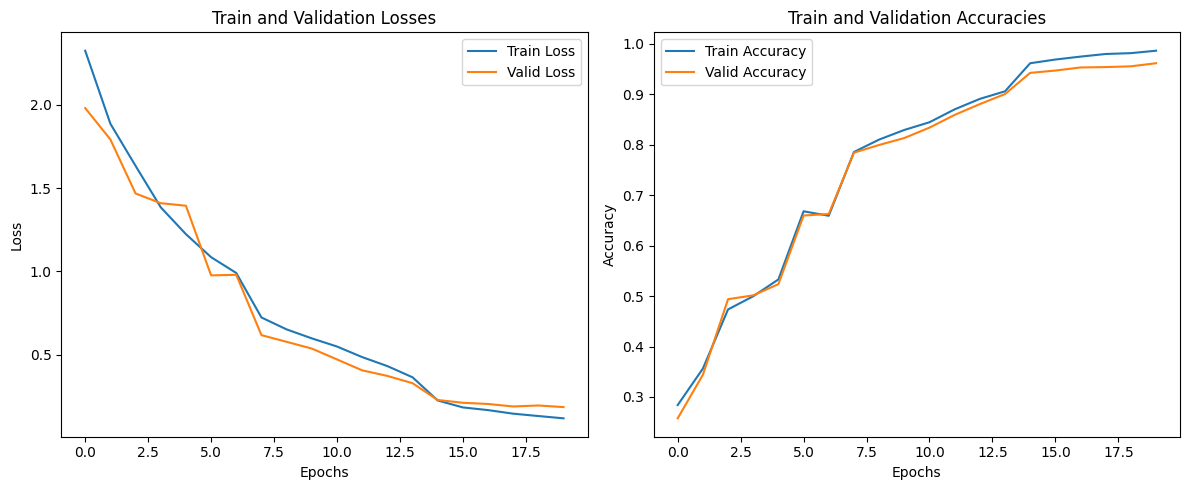

In [35]:
train_losses=[]
valid_losses=[]
best_valid_accuracy = 0.0
patience_counter = 0
patience = 5
train_accuracies = []  
valid_accuracies = []

for epoch in range(EPOCHS):
  start_time=time.time()
  train_loss=train(model,train_loader,optimizer,criterion)
  valid_loss=validate(model,valid_loader,criterion)
  train_accuracy=compute_accuracy(model,train_loader)
  valid_accuracy=compute_accuracy(model,valid_loader)

  end_time=time.time()
  epoch_time=end_time-start_time

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(train_accuracy) 
  valid_accuracies.append(valid_accuracy)

  if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy=valid_accuracy
        best_model_path=os.path.join(saving_dir,f"Num_{epoch}_best_model.pt")
        torch.save(model.state_dict(),best_model_path)
        patience_encounter=0
  else:
    patience_counter+=1

  tqdm.write(f'Epoch {epoch+1}/{EPOCHS},'
             f'Train Loss: {train_loss:.4f},'
             f'Valid Loss: {valid_loss:.4f},'
             f'Train Accuracy: {train_accuracy:.4f},'
             f'Valid Accuracy: {valid_accuracy:.4f},'
             f'Time taken for Epoch:{epoch_time:.2f} seconds'

  )
  scheduler.step()
    
  if patience_counter >= patience:
    tqdm.write('Early Stopping Triggered')
    break

    
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

#### 

In [37]:
def load_model(epoch,model):
    model_path=os.path.join(saving_dir,f'Num_{epoch}_best_model.pt')
    model.load_state_dict(torch.load(model_path))
    return model

def eva_model_on_test(model,test_loader):
    model.eval()
    test_accuracy=compute_accuracy(model,test_loader)
    return test_accuracy


model_20=load_model(19,model)
# model_8=load_model(8,model)

acc_model_20=eva_model_on_test(model_20,test_loader)
# acc_model_7=eva_model_on_test(model_7,test_loader)

print(f'Test accuracy of model at epoch 14: {acc_model_20:.5f}')
# print(f'Test accuracy of model at epoch 8: {acc_model_7:.5f}')

Test accuracy of model at epoch 14: 0.95894


In [39]:
model_20.eval()

true_labels=[]
predicted_labels=[]
missclassified_indices=[]
missclassified_images=[]
missclassified_true_labels=[]
missclassified_pred_labels=[]

with torch.no_grad():
    for i,(inputs,labels) in enumerate(test_loader):
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        outputs=model(inputs)
        probs=FF.softmax(outputs,dim=1)
        
        true_labels.extend(labels.cpu().numpy())
        preds=np.argmax(probs.cpu().numpy(),axis=1)
        predicted_labels.extend(preds)
        
        for j in range (len(labels)):
            if preds[j] != labels.cpu().numpy()[j]:
                missclassified_indices.append(i* test_loader.batch_size+j)
                missclassified_images.append(inputs.cpu().numpy()[j])
                missclassified_true_labels.append(labels.cpu().numpy()[j])
                missclassified_pred_labels.append(preds[j])
        
        

test_report=classification_report(true_labels,predicted_labels,target_names=test_dataset.classes)

print(test_report)

              precision    recall  f1-score   support

   butterfly       0.94      0.96      0.95       106
         cat       0.98      0.95      0.96        84
     chicken       0.97      0.97      0.97       155
         cow       0.91      0.97      0.94        94
         dog       0.95      1.00      0.97       244
    elephant       1.00      0.96      0.98        73
       horse       0.97      0.89      0.93       132
       ragno       0.98      0.93      0.96       242
       sheep       0.98      0.98      0.98        91
    squirrel       0.92      0.99      0.95        94

    accuracy                           0.96      1315
   macro avg       0.96      0.96      0.96      1315
weighted avg       0.96      0.96      0.96      1315



<function matplotlib.pyplot.show(close=None, block=None)>

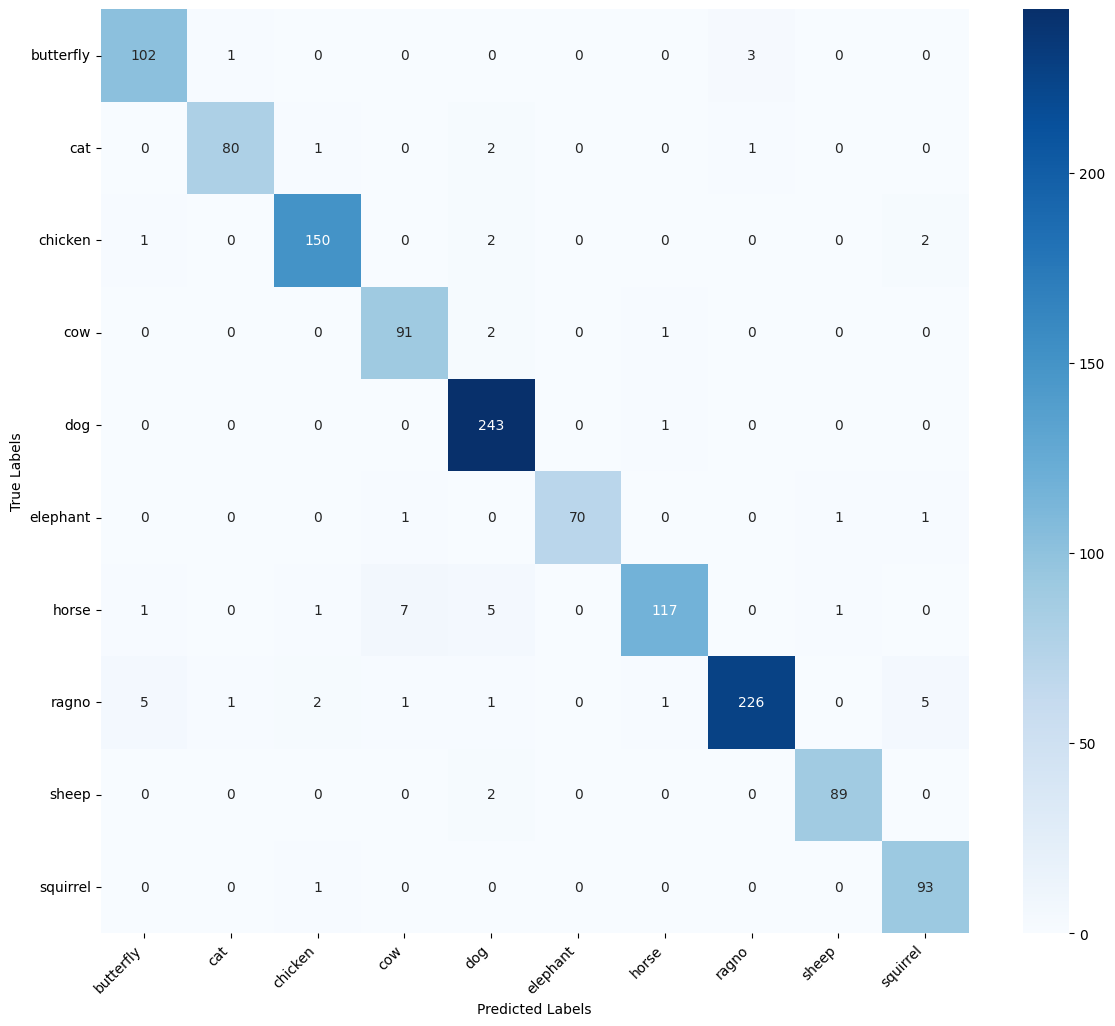

In [40]:
conf_matrix=confusion_matrix(true_labels,predicted_labels)

cmap=plt.cm.Blues
plt.figure(figsize=(14,12))

sns.heatmap(conf_matrix,annot=True,fmt='d',cmap=cmap, xticklabels=test_dataset.classes,yticklabels=test_dataset.classes)

plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)

# plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show

In [41]:
len(missclassified_images)

54

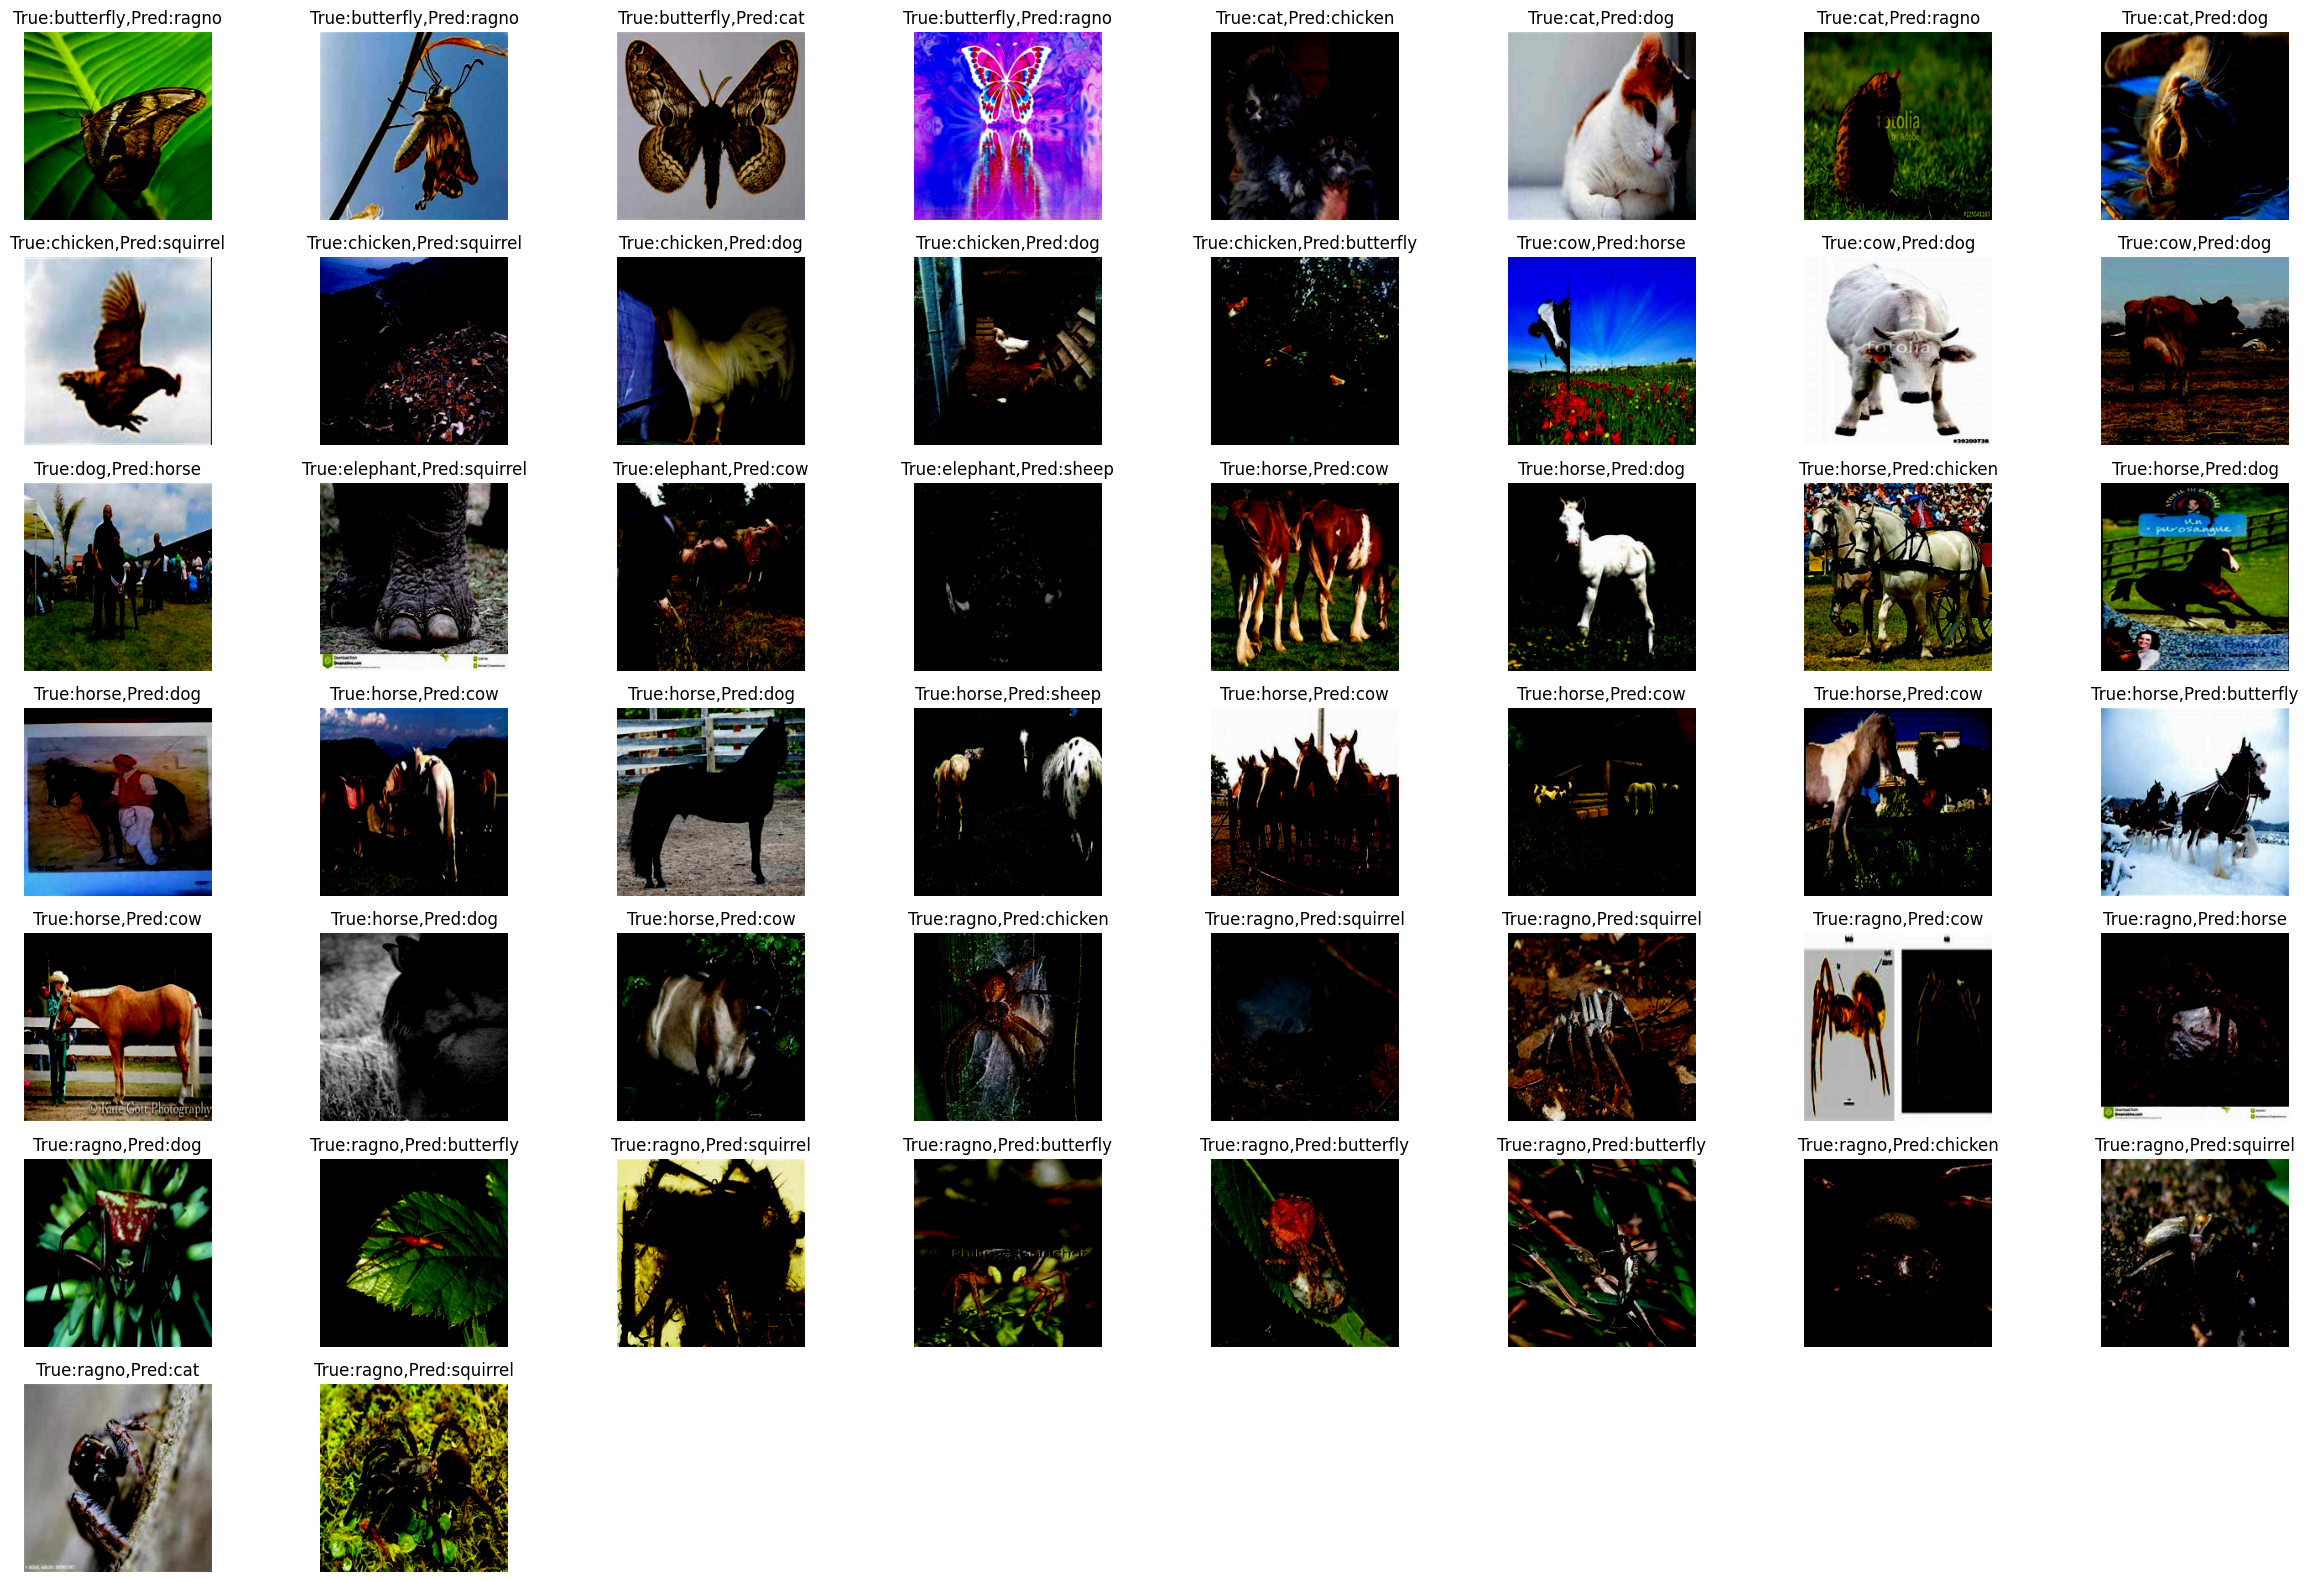

In [42]:
nums_images_to_display=min(50,len(missclassified_images))

plt.figure(figsize=(30,20))

for i in range(nums_images_to_display):
    plt.subplot(7,8,i+1)
    
    img=missclassified_images[i].transpose((1,2,0))
    plt.imshow(img)
    plt.title(f'True:{test_dataset.classes[missclassified_true_labels[i]]},Pred:{test_dataset.classes[missclassified_pred_labels[i]]}')
    plt.axis("off")
    
    
    
plt.show()